In [1]:
# Import of libraries
import random
import numpy as np
import matplotlib.pyplot as plt

import einops
import torch
import torch.nn as nn
from torch.optim import Adam
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import DataLoader, Dataset
import matplotlib.animation as animation

from pathlib import Path
import os
from matplotlib import cm
from matplotlib.ticker import LinearLocator

SEED = 20240507
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.set_default_dtype(torch.float32)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_dir = Path("data")
model_dir = Path("models")
pic_dir = Path("pictures")
if not os.path.exists(data_dir):
    os.mkdir(data_dir)
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
if not os.path.exists(pic_dir):
    os.mkdir(pic_dir)

In [3]:
def sample_from_potential(fn, n_sample=1000, data_dim=2, steps=100, step_size=0.1,
                          initial="uniform", data_min=-10, data_max=10,
                         ):
    if initial=='uniform':
        uniform_min = [data_min] * data_dim
        uniform_max = [data_max] * data_dim
        initial_position = np.random.uniform(low=uniform_min, high=uniform_max, size=[n_sample,data_dim])
    else:
        initial_position = np.random.normal(scale=step_size, size=2)
    
    current_position = initial_position
    current_energy = fn(current_position)
    
    for i in (range(1, steps)):
        # Propose a new position
        proposal = current_position + np.random.normal(scale=step_size, size=[n_sample,data_dim])
        proposal_energy = fn(proposal)
        
        # Calculate the Metropolis acceptance criterion
        # Since we're sampling from e^(-energy), we need to compare exponentials of negative energies
        accept_matrix = np.random.rand() < np.exp(current_energy - proposal_energy)
        # print(accept_matrix)
        current_position[accept_matrix] = proposal[accept_matrix]
        current_energy[accept_matrix] = proposal_energy[accept_matrix]

    return current_position
    

In [4]:
def C2_potential_2d(x, a=0.5, b=10., c=8):
    if len(x.shape) == 1:
        x = x[:,None]
    return (x[:,1]**2 * (a*(x[:,1]**2)-b) + (c/2)*(x[:,0]-x[:,1])**2 )/10.

def C4_potential_energy_2d(x, a=2, b=20):
    theta = np.pi/3.
    rot_mat = np.array([[np.cos(theta), -np.sin(theta), 0],
                                 [np.sin(theta), np.cos(theta), 0]])
    r_x = x @ rot_mac
    def pot(y, k_4=a, k_2=b):
        return 0.5 * (np.sum(k_4*y**4, axis=-1)-np.sum(k_2*y**2, axis=-1))
    return (pot(x) + pot(r_x)*0.7)/6

In [75]:
sampled_positions = sample_from_potential(C4_potential_energy_2d, 
                                          n_sample=100000, steps=5000, 
                                          step_size=0.05, data_min=-6, data_max=6)
print("Sampled positions:\n", sampled_positions.shape)
np.save(data_dir/"C4_2d_100000.npy", sampled_positions)

Sampled positions:
 (100000, 2)


In [76]:
sampled_positions = sample_from_potential(C2_potential_energy_2d, 
                                          n_sample=100000, steps=5000, 
                                          step_size=0.05, data_min=-6, data_max=6)
print("Sampled positions:\n", sampled_positions.shape)
np.save(data_dir/"C2_2d_100000.npy", sampled_positions)

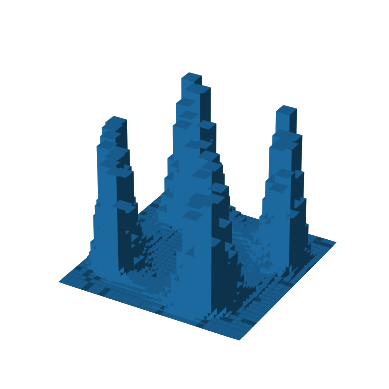

In [27]:
import matplotlib.colors as colors
resolution = 50
# H, edges = np.histogramdd(sampled_positions, bins = (resolution, resolution), range=([-3,3],[-3,3]))
x = np.linspace(-3., 3., resolution)
y = np.linspace(-3., 3., resolution)
xv, yv = np.meshgrid(x, y)
xy_pairs = np.array(list(zip(xv.flatten(), yv.flatten())))

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})


hist, xedges, yedges = np.histogram2d(sampled_positions[:,0], sampled_positions[:,1], bins=30, density=True)

# Construct arrays for the anchor positions of the bars.
xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0

# Construct arrays with the dimensions for the 16 bars.
dx = dy = 0.5 * np.ones_like(zpos)

dz = hist.ravel()

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average')

ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')
# plt.show()
# Hide grid lines
ax.grid(False)
# Hide axes ticks
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
color_tuple = (1.0, 1.0, 1.0, 0.0)
ax.xaxis.set_pane_color(color_tuple)
ax.yaxis.set_pane_color(color_tuple)
ax.zaxis.set_pane_color(color_tuple)
ax.xaxis.line.set_color(color_tuple)
ax.yaxis.line.set_color(color_tuple)
ax.zaxis.line.set_color(color_tuple)
plt.savefig("pictures/data_C4.png", transparent=True)

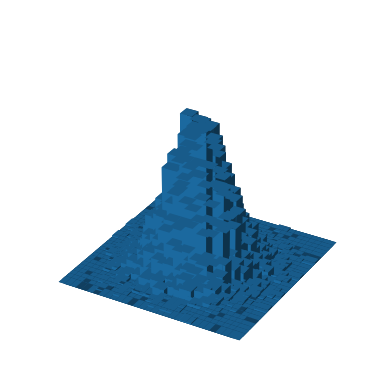

In [32]:

resolution = 50
# H, edges = np.histogramdd(sampled_positions, bins = (resolution, resolution), range=([-3,3],[-3,3]))
x = np.linspace(-3., 3., resolution)
y = np.linspace(-3., 3., resolution)
xv, yv = np.meshgrid(x, y)
xy_pairs = np.array(list(zip(xv.flatten(), yv.flatten())))

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

normal_samples = np.random.normal(size=(10000, 2))
hist, xedges, yedges = np.histogram2d(normal_samples[:,0], normal_samples[:,1], bins=30, density=True)

# Construct arrays for the anchor positions of the bars.
xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0

# Construct arrays with the dimensions for the 16 bars.
dx = dy = 0.5 * np.ones_like(zpos)

dz = hist.ravel()

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average')

ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')
# plt.show()
# Hide grid lines
ax.grid(False)
# Hide axes ticks
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
color_tuple = (1.0, 1.0, 1.0, 0.0)
ax.xaxis.set_pane_color(color_tuple)
ax.yaxis.set_pane_color(color_tuple)
ax.zaxis.set_pane_color(color_tuple)
ax.xaxis.line.set_color(color_tuple)
ax.yaxis.line.set_color(color_tuple)
ax.zaxis.line.set_color(color_tuple)
plt.savefig("pictures/priot_dis.png", transparent=True)

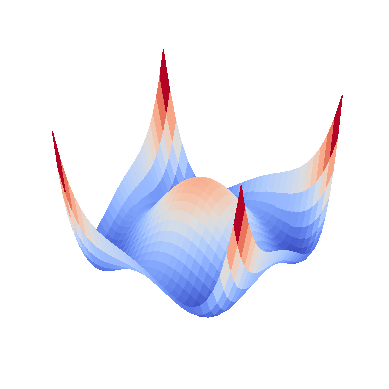

In [16]:
resolution = 30
x = np.linspace(-3., 3., resolution)
y = np.linspace(-3., 3., resolution)
xv, yv = np.meshgrid(x, y)
xy_pairs = np.array(list(zip(xv.flatten(), yv.flatten())))
all_energy = C4_potential_energy_2d(xy_pairs)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(xv, yv, all_energy.reshape(resolution, resolution), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')
# plt.show()
# Hide grid lines
ax.grid(False)
# Hide axes ticks
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
color_tuple = (1.0, 1.0, 1.0, 0.0)
ax.xaxis.set_pane_color(color_tuple)
ax.yaxis.set_pane_color(color_tuple)
ax.zaxis.set_pane_color(color_tuple)
ax.xaxis.line.set_color(color_tuple)
ax.yaxis.line.set_color(color_tuple)
ax.zaxis.line.set_color(color_tuple)
plt.savefig("pictures/surface_C4.png", transparent=True)

# plt.pcolormesh(xv, yv, all_energy.reshape(resolution, resolution), shading='gouraud', )
# plt.colorbar()
# plt.show()

In [34]:
class SampleDataset(Dataset):
    def __init__(self, samples, transform=None, device=None):
        self.samples = torch.from_numpy(samples).float()
        self.transform = transform
        if device is not None:
            self.samples.to(device)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample, 0

In [35]:
# DDPM class
class MyDDPM(nn.Module):
    def __init__(self, network, n_steps=200, min_beta=10 ** -4, max_beta=0.02, device=None, image_chw=(1, 28, 28)):
        super(MyDDPM, self).__init__()
        self.n_steps = n_steps
        self.device = device
        self.network = network.to(device)
        self.betas = torch.linspace(min_beta, max_beta, n_steps).to(device)  # Number of steps is typically in the order of thousands
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.tensor([torch.prod(self.alphas[:i + 1]) for i in range(len(self.alphas))]).to(device)

    def forward(self, x0, t, eta=None):
        # Make input image more noisy (we can directly skip to the desired step)
        n, d = x0.shape
        a_bar = self.alpha_bars[t]
        if eta is None:
            eta = torch.randn(n, d).to(self.device)
        noisy = a_bar.sqrt().reshape(n, 1) * x0 + (1 - a_bar).sqrt().reshape(n, 1) * eta
        return noisy

    def backward(self, x, t):
        return self.network(x, t)

    
def 1(n, d):
    # Returns the standard positional embedding
    embedding = torch.zeros(n, d)
    wk = torch.tensor([1 / 10_000 ** (2 * j / d) for j in range(d)])
    wk = wk.reshape((1, d))
    t = torch.arange(n).reshape((n, 1))
    embedding[:,::2] = torch.sin(t * wk[:,::2])
    embedding[:,1::2] = torch.cos(t * wk[:,::2])
    return embedding

    
class SimpleNet(nn.Module):
    def __init__(
        self,
        dim,
        hidden_dim=64,
        n_steps=1000, 
        time_emb_dim=100
    ):
        super(SimpleNet, self).__init__()
        self.input_layer = nn.Linear(dim, hidden_dim)
        self.layer1 = nn.Linear(hidden_dim, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.layer3 = nn.Linear(hidden_dim, hidden_dim)
        self.layer4 = nn.Linear(hidden_dim, dim)
        self.activation = nn.SiLU()
        

        # Sinusoidal embedding
        self.time_embed = nn.Embedding(n_steps, time_emb_dim)
        self.time_embed.weight.data = sinusoidal_embedding(n_steps, time_emb_dim)
        self.time_embed.requires_grad_(False)
        self.te1 = self._make_te(time_emb_dim, dim)
        self.te2 = self._make_te(time_emb_dim, hidden_dim)
        self.te3 = self._make_te(time_emb_dim, hidden_dim)
        self.te4 = self._make_te(time_emb_dim, hidden_dim)
        self.te5 = self._make_te(time_emb_dim, hidden_dim)
    
    def forward(self, x, t):
        t = self.time_embed(t)
        n = len(x)
        x = self.input_layer(x + self.te1(t).reshape(n, -1))
        x = self.activation(x)
        x = self.layer1(x + self.te2(t))
        x = self.activation(x)
        x = self.layer2(x + self.te3(t))
        x = self.activation(x)
        x = self.layer3(x + self.te4(t))
        x = self.activation(x)
        x = self.layer4(x + self.te5(t))
        return x
    
    def _make_te(self, dim_in, dim_out):
        return nn.Sequential(
            nn.Linear(dim_in, dim_out),
            nn.SiLU(),
            nn.Linear(dim_out, dim_out)
        )

In [36]:
def training_loop(ddpm, loader, n_epochs, optim, scheduler, device, print_interval=2, store_path="ddpm_model.pt"):
    mse = nn.MSELoss()
    best_loss = float("inf")
    n_steps = ddpm.n_steps

    for epoch in range(n_epochs):
        epoch_loss = 0.0
        for step, batch in enumerate(loader):
            # Loading data
            x0 = batch[0].to(device)
            n = len(x0)

            # Picking some noise for each of the images in the batch, a timestep and the respective alpha_bars
            eta = torch.randn_like(x0).to(device)
            t = torch.randint(0, n_steps, (n,)).to(device)

            # Computing the noisy image based on x0 and the time-step (forward process)
            noisy_imgs = ddpm(x0, t, eta)

            # Getting model estimation of noise based on the images and the time-step
            eta_theta = ddpm.backward(noisy_imgs, t)
            # Optimizing the MSE between the noise plugged and the predicted noise
            loss = mse(eta_theta, eta)
            optim.zero_grad()
            loss.backward()
            optim.step()

            epoch_loss += loss.item() * len(x0) / len(loader.dataset)
        scheduler.step()

        log_string = f"Loss at epoch {epoch + 1}: {epoch_loss:.3f}"

        # Storing the model
        if best_loss > epoch_loss:
            best_loss = epoch_loss
            torch.save(ddpm.state_dict(), store_path)
            log_string += " --> Best model ever (stored)"
        
        if epoch % print_interval == 0:
            print(log_string)
    

In [93]:
n_steps, min_beta, max_beta = 1000, 10 ** -4, 0.02  # Originally used by the authors
batch_size = 1024
n_epochs = 50
lr = 0.0005

store_path = model_dir/"ddpm_model_C2_2d.pt"
sampled_positions = np.load(data_dir/"C2_2d_100000.npy")
dataset = SampleDataset(sampled_positions, device=device)
loader = DataLoader(dataset, batch_size, shuffle=True)
model = SimpleNet(dim=2, hidden_dim=128, n_steps=n_steps)
ddpm = MyDDPM(model, n_steps=n_steps, min_beta=min_beta, max_beta=max_beta, device=device)
optimizer = Adam(ddpm.parameters(), lr = lr)
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [94]:
def count_model_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return {'total': total_params, 'trainable': trainable_params}
print(count_model_parameters(ddpm))

{'total': 268146, 'trainable': 168146}


In [95]:
training_loop(ddpm, loader, n_epochs, optimizer, scheduler, device, print_interval=5, store_path=store_path)

Loss at epoch 1: 0.554 --> Best model ever (stored)
Loss at epoch 6: 0.290 --> Best model ever (stored)
Loss at epoch 11: 0.284 --> Best model ever (stored)
Loss at epoch 16: 0.283
Loss at epoch 21: 0.282
Loss at epoch 26: 0.280
Loss at epoch 31: 0.282
Loss at epoch 36: 0.280
Loss at epoch 41: 0.280
Loss at epoch 46: 0.280


In [37]:
def generate_new_samples(ddpm, n_samples=10000, device=None, d=2, min_t=0.0):
    """Given a DDPM model, a number of samples to be generated and a device, returns some newly generated samples"""
    frames = []

    with torch.no_grad():
        
        if device is None:
            device = ddpm.device

        # Starting from random noise
        x = torch.randn(n_samples, d).to(device)

        for idx, t in enumerate(list(range(ddpm.n_steps))[::-1]):
            # Estimating noise to be removed
            if t < min_t * ddpm.n_steps-1:
                t = int(min_t * ddpm.n_steps)
            time_tensor = (torch.ones(n_samples, ) * t).to(device).long()
            eta_theta = ddpm.backward(x, time_tensor)
            
            alpha_t = ddpm.alphas[t]
            alpha_t_bar = ddpm.alpha_bars[t]

            # Partially denoising the image
            x = (1 / alpha_t.sqrt()) * (x - (1 - alpha_t) / (1 - alpha_t_bar).sqrt() * eta_theta)
            

            if t > 0:
                z = torch.randn(n_samples, d).to(device)

                # Option 1: sigma_t squared = beta_t
                beta_t = ddpm.betas[t]
                sigma_t = beta_t.sqrt()

                # Option 2: sigma_t squared = beta_tilda_t
                # prev_alpha_t_bar = ddpm.alpha_bars[t-1] if t > 0 else ddpm.alphas[0]
                # beta_tilda_t = ((1 - prev_alpha_t_bar)/(1 - alpha_t_bar)) * beta_t
                # sigma_t = beta_tilda_t.sqrt()

                # Adding some more noise like in Langevin Dynamics fashion
                x = x + sigma_t * z                
    
    return x

In [8]:
n_steps, min_beta, max_beta = 1000, 10 ** -4, 0.02  # Originally used by the authors
model = SimpleNet(dim=2, hidden_dim=128, n_steps=n_steps)
best_model = MyDDPM(model, n_steps=n_steps, device=device)
best_model.load_state_dict(torch.load(model_dir/"ddpm_model_double_well_2d.pt", map_location=device))
best_model.eval()
print("model loaded.")

model loaded.


In [31]:
samples_dir = data_dir/"samples"

if not os.path.exists(samples_dir):
    os.mkdir(samples_dir)

total_idx = 100
for i in range(1, total_idx):
    new_sample = generate_new_samples(best_model, n_samples=100000, min_t=(1-i/total_idx)).cpu().numpy()
    np.save(samples_dir/f"sample_{i}_double_well_2d.npy", new_sample)

In [32]:
vf_dir = data_dir/"vector_field"

if not os.path.exists(vf_dir):
    os.mkdir(vf_dir)
resolution = 10
x = np.linspace(-3., 3., resolution)
y = np.linspace(-3., 3., resolution)
xv, yv = np.meshgrid(x, y)
xy_pairs = np.array(list(zip(xv.flatten(), yv.flatten())))
xy_tensor = torch.from_numpy(xy_pairs).to(device).float()

best_model.eval()
for i in range(1, ddpm.n_steps):
    time_tensor = (torch.ones(len(xy_tensor), ) * i).to(device).long()
    eta_theta = best_model.backward(xy_tensor, time_tensor).detach().cpu().numpy()
    np.save(vf_dir/f"vf_{i}_double_well_2d.npy", eta_theta)

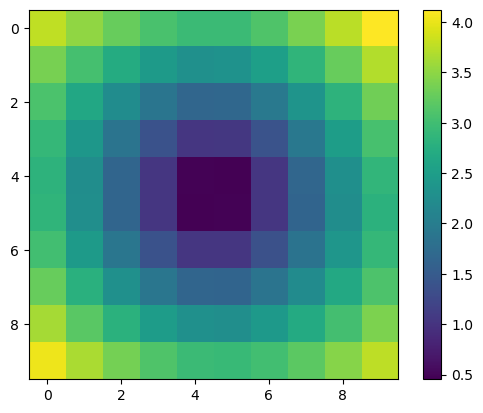

In [41]:
vf_dir = data_dir/"vector_field"
vf_i = np.load(vf_dir/f"vf_999_double_well_2d.npy").reshape(10, 10, 2)
plt.figure()
plt.imshow(np.sqrt(vf_i[:,:,1]**2+vf_i[:,:,0]**2))
plt.colorbar()
plt.show()

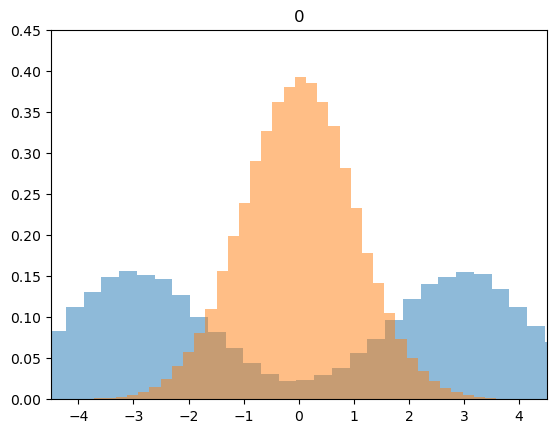

In [39]:
fig, ax = plt.subplots()

ax.hist(sampled_positions[:,0], bins=50, density=True, alpha=0.5)
ax.set_ylim([0.0, 0.45])
ax.set_xlim([-4.5, 4.5])

def update(frame_number):
    ax.cla()
    data = np.load(samples_dir/f"sample_{frame_number+1}_double_well_2d.npy")    
    ax.hist(sampled_positions[:,0], bins=50, density=True, alpha=0.5)
    ax.hist(data[:,0], bins=50, density=True, alpha=0.5)
    ax.set_title(f'{frame_number}')
    ax.set_ylim([0.0, 0.45])
    ax.set_xlim([-4.5, 4.5])
    # ax.axis('equal')
    

ani = animation.FuncAnimation(fig, update, repeat=False, frames=99, interval=70)
ani.save(pic_dir/'scatter_double_well.gif')

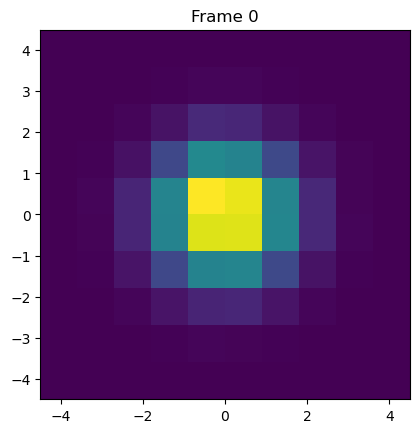

In [47]:

fig, ax = plt.subplots()
def update(frame_number):
    # Clear the current histogram
    ax.cla()
    # Plot new data
    # new_sample = generate_new_images(best_model, min_t=(1-frame_number/10)).cpu().numpy()
    data = np.load(samples_dir/f"sample_{frame_number+1}_double_well_2d.npy")    
    H, edges = np.histogramdd(data, bins = (resolution, resolution), range=([-4.5, 4.5], [-4.5, 4.5]))
    ax.pcolormesh(edges[0], edges[1], H)
    ax.set_title(f'Frame {frame_number}')
    ax.set_ylim([-4.5, 4.5])
    ax.set_xlim([-4.5, 4.5])
    ax.set_aspect('equal', adjustable='box')


ani = animation.FuncAnimation(fig, update, repeat=False, frames=99, interval=50)
# ani = animation.FuncAnimation(fig, update, repeat=False, frames=3, interval=20)

ani.save(pic_dir/'samples_double_well_2d.gif')

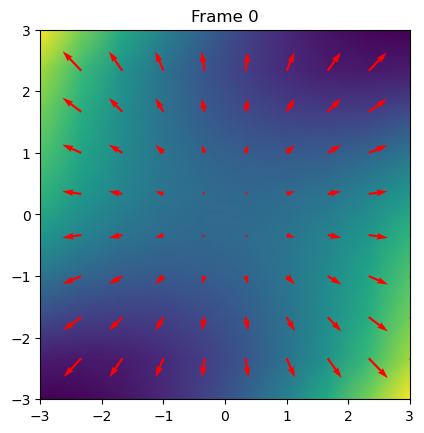

In [41]:
all_energy = double_well_potential_2d(xy_pairs)
np.save(data_dir/"energy_double_well_2d.npy", all_energy)
fig, ax = plt.subplots()
def update(frame_number):
    # Clear the current histogram
    ax.cla()
    # Plot new data
    # new_sample = generate_new_images(best_model, min_t=(1-frame_number/10)).cpu().numpy()
    data = np.load(vf_dir/f"vf_{best_model.n_steps-frame_number-1}_double_well_2d.npy")
    ax.pcolormesh(xv, yv, all_energy.reshape(resolution, resolution), shading='gouraud')
    ax.quiver(
        xy_pairs[:,0],
        xy_pairs[:,1],
        data[:,0],
        data[:,1],
        color="red"
    )
    ax.set_title(f'Frame {frame_number}')
    ax.set_aspect('equal', adjustable='box')

ani = animation.FuncAnimation(fig, update, repeat=False, frames=best_model.n_steps-1, interval=20)
ani.save(pic_dir/'vector_field_double_well_2d.gif')

# For C4 data

In [ ]:
n_steps, min_beta, max_beta = 1000, 10 ** -4, 0.02  # Originally used by the authors
batch_size = 1024
n_epochs = 50
lr = 0.0005

store_path = model_dir/"ddpm_model_C4_2d.pt"
sampled_positions = np.load(data_dir/"C4_2d_100000.npy")
dataset = SampleDataset(sampled_positions, device=device)
loader = DataLoader(dataset, batch_size, shuffle=True)
model = SimpleNet(dim=2, hidden_dim=128, n_steps=n_steps)
ddpm = MyDDPM(model, n_steps=n_steps, min_beta=min_beta, max_beta=max_beta, device=device)
optimizer = Adam(ddpm.parameters(), lr = lr)
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [ ]:
training_loop(ddpm, loader, n_epochs, optimizer, scheduler, device, print_interval=5, store_path=store_path)

In [38]:
n_steps, min_beta, max_beta = 1000, 10 ** -4, 0.02  # Originally used by the authors
model = SimpleNet(dim=2, hidden_dim=128, n_steps=n_steps)
best_model = MyDDPM(model, n_steps=n_steps, device=device)
best_model.load_state_dict(torch.load(model_dir/"ddpm_model_C4_2d.pt", map_location=device))
best_model.eval()
print("model loaded.")

model loaded.


In [101]:
vf_dir = data_dir/"vector_field"

if not os.path.exists(vf_dir):
    os.mkdir(vf_dir)
resolution = 10
x = np.linspace(-3., 3., resolution)
y = np.linspace(-3., 3., resolution)
xv, yv = np.meshgrid(x, y)
xy_pairs = np.array(list(zip(xv.flatten(), yv.flatten())))
xy_tensor = torch.from_numpy(xy_pairs).to(device).float()

best_model.eval()
for i in range(1, ddpm.n_steps):
    time_tensor = (torch.ones(len(xy_tensor), ) * i).to(device).long()
    eta_theta = best_model.backward(xy_tensor, time_tensor).detach().cpu().numpy()
    np.save(vf_dir/f"vf_{i}_C4_2d.npy", eta_theta)

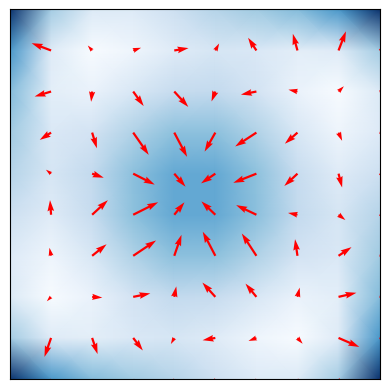

In [33]:
resolution = 10
vf_dir = data_dir/"vector_field"
x = np.linspace(-3., 3., resolution)
y = np.linspace(-3., 3., resolution)
xv, yv = np.meshgrid(x, y)
xy_pairs = np.array(list(zip(xv.flatten(), yv.flatten())))
all_energy = C4_potential_energy_2d(xy_pairs)
np.save(data_dir/"energy_C4_2d.npy", all_energy)
data = np.load(vf_dir/f"vf_100_C4_2d.npy")
fig, ax = plt.subplots()
all_energy = C4_potential_energy_2d(xy_pairs)
ax.pcolormesh(xv, yv, all_energy.reshape(resolution, resolution), shading='gouraud', cmap="Blues")
ax.quiver(
        xy_pairs[:,0],
        xy_pairs[:,1],
        data[:,0],
        data[:,1],
        color="red"
    )
ax.grid(False)
# Hide axes ticks
ax.set_xticks([])
ax.set_yticks([])

ax.set_aspect('equal', adjustable='box')
plt.savefig("pictures/vf_C4.png", transparent=True)

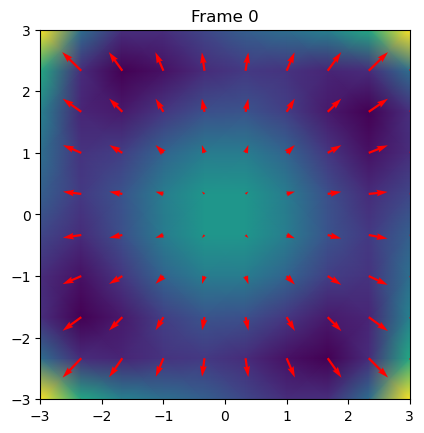

In [102]:
resolution = 10
x = np.linspace(-3., 3., resolution)
y = np.linspace(-3., 3., resolution)
xv, yv = np.meshgrid(x, y)
xy_pairs = np.array(list(zip(xv.flatten(), yv.flatten())))
all_energy = C4_potential_energy_2d(xy_pairs)
np.save(data_dir/"energy_C4_2d.npy", all_energy)
fig, ax = plt.subplots()
pic_dir = Path("pictures")
def update(frame_number):
    # Clear the current histogram
    ax.cla()
    # Plot new data
    # new_sample = generate_new_images(best_model, min_t=(1-frame_number/10)).cpu().numpy()
    data = np.load(vf_dir/f"vf_{best_model.n_steps-frame_number-1}_C4_2d.npy")
    ax.pcolormesh(xv, yv, all_energy.reshape(resolution, resolution), shading='gouraud')
    ax.quiver(
        xy_pairs[:,0],
        xy_pairs[:,1],
        data[:,0],
        data[:,1],
        color="red"
    )
    ax.set_title(f'Frame {frame_number}')
    ax.set_aspect('equal', adjustable='box')

ani = animation.FuncAnimation(fig, update, repeat=False, frames=best_model.n_steps-1, interval=20)
ani.save(pic_dir/'vector_field_C4_2d.gif')